# Car Price Prediction

<b>Notebook has following sections:<b>

1- Data understanding and exploration 

2- Data cleaning

3- Data preparation: Feature Engineering and Scaling

4- Feature Selection using RFE and Model Building  

5- Linear Regression Assumptions Validation and Outlier Removal

6- Rebuilding the Model Post Outlier Removal: Feature Selection using K-Fold Cross Validation & RFE  

7- Removing Multicollinearity, Model Re-evaluation and Assumptions Validation 

# Section 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [305]:
cars = pd.read_csv("CarPrice_Assignment.csv")
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [306]:
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


#### Understanding the features and data

In [307]:
# symboling: -2 (least risky) to +3 most risky
# Most cars are 0,1,2
cars['symboling'].astype('category').value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

In [308]:
# aspiration: An (internal combustion) engine property showing 
# whether the oxygen intake is through standard (atmospheric pressure)
# or through turbocharging (pressurised oxygen intake)
cars['aspiration'].astype('category').value_counts()

std      168
turbo     37
Name: aspiration, dtype: int64

In [309]:
# drivewheel: frontwheel, rear wheel or four-wheel drive 
cars['drivewheel'].astype('category').value_counts()

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

![](wheel-drives.png)

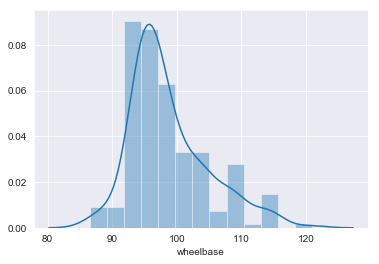

In [310]:
# wheelbase: distance between centre of front and rear wheels
sns.distplot(cars['wheelbase'])
plt.show()

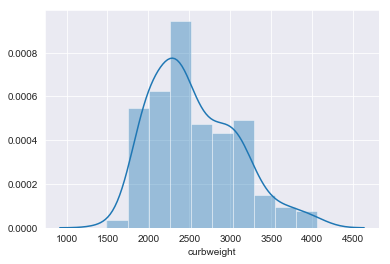

In [311]:
# curbweight: weight of car without occupants or baggage
sns.distplot(cars['curbweight'])

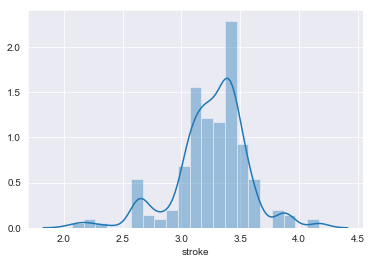

In [312]:
# stroke: volume of the engine (the distance traveled by the 
# piston in each cycle)
sns.distplot(cars['stroke'])
plt.show()

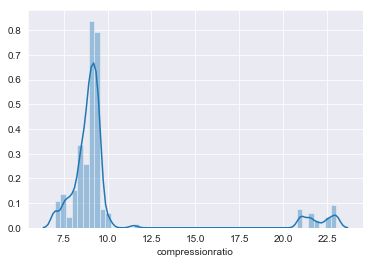

In [313]:
# compression ration: ration of volume of compression chamber 
# at largest capacity to least capacity
sns.distplot(cars['compressionratio'])
plt.show()

Text(0.5, 1.0, 'Density or Relative Frequency Of Cars By Price')

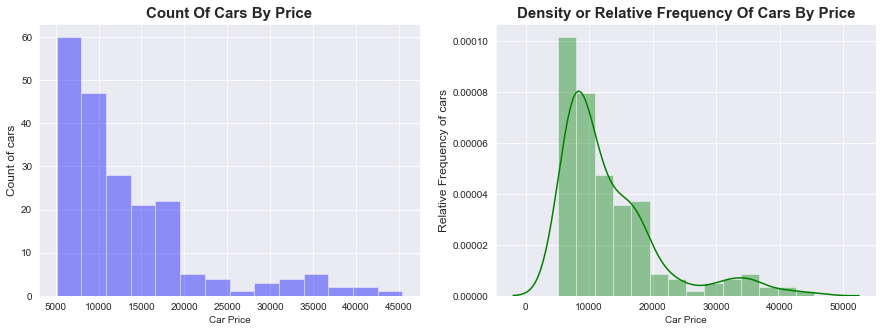

In [314]:
# target variable: price of car

fig, ax= plt.subplots(1,2,figsize=(15,5))

sns.distplot(cars['price'], norm_hist=False, kde=False, ax=ax[0], color='blue')
ax[0].set_xlabel('Car Price')
ax[0].set_ylabel('Count of cars',size=12)
ax[0].set_title('Count Of Cars By Price',size=15,weight="bold")

sns.distplot(cars['price'], kde=True, ax=ax[1], color='green')
ax[1].set_xlabel('Car Price')
ax[1].set_ylabel('Relative Frequency of cars',size=12)
ax[1].set_title('Density or Relative Frequency Of Cars By Price',size=15,weight="bold")



# Observations on Target Variable- Price:
    
1. The target variable price has a positive skew, however majority of the cars are low priced.


2. More than 50% of the cars (around 105-107 out of total of 205) are priced 10,000 and close to 35% cars are priced 
   between 10,000 and 20,000. So around 85% of cars in US market are priced between 5,000 to 20,000. 
   
    
3. Based on above observations and graph on right side (KDE/green one) it appears there are 2 distributions one for cars priced 
   between 5,000 and 25000 and another distribution for high priced cars 25,000 and above. (Notice the approximate bell curve  
   from little less than 30000 upto 45,000/50,000)


# Data Exploration

To perform linear regression, the target variable should be linearly related to independent variables. Let's see whether that's true in this case.

In [315]:
#creating df  with numeric var's only
cars_numeric=cars.select_dtypes(include=['float64','int64'])
cars_numeric.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [316]:
# dropping symboling and car_ID as symboling is more of categorical variable as described before and car_ID is only 
#an index type variable and not a predictor
cars_numeric = cars_numeric.drop(['symboling', 'car_ID'], axis=1)
cars_numeric.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


<Figure size 1440x720 with 0 Axes>

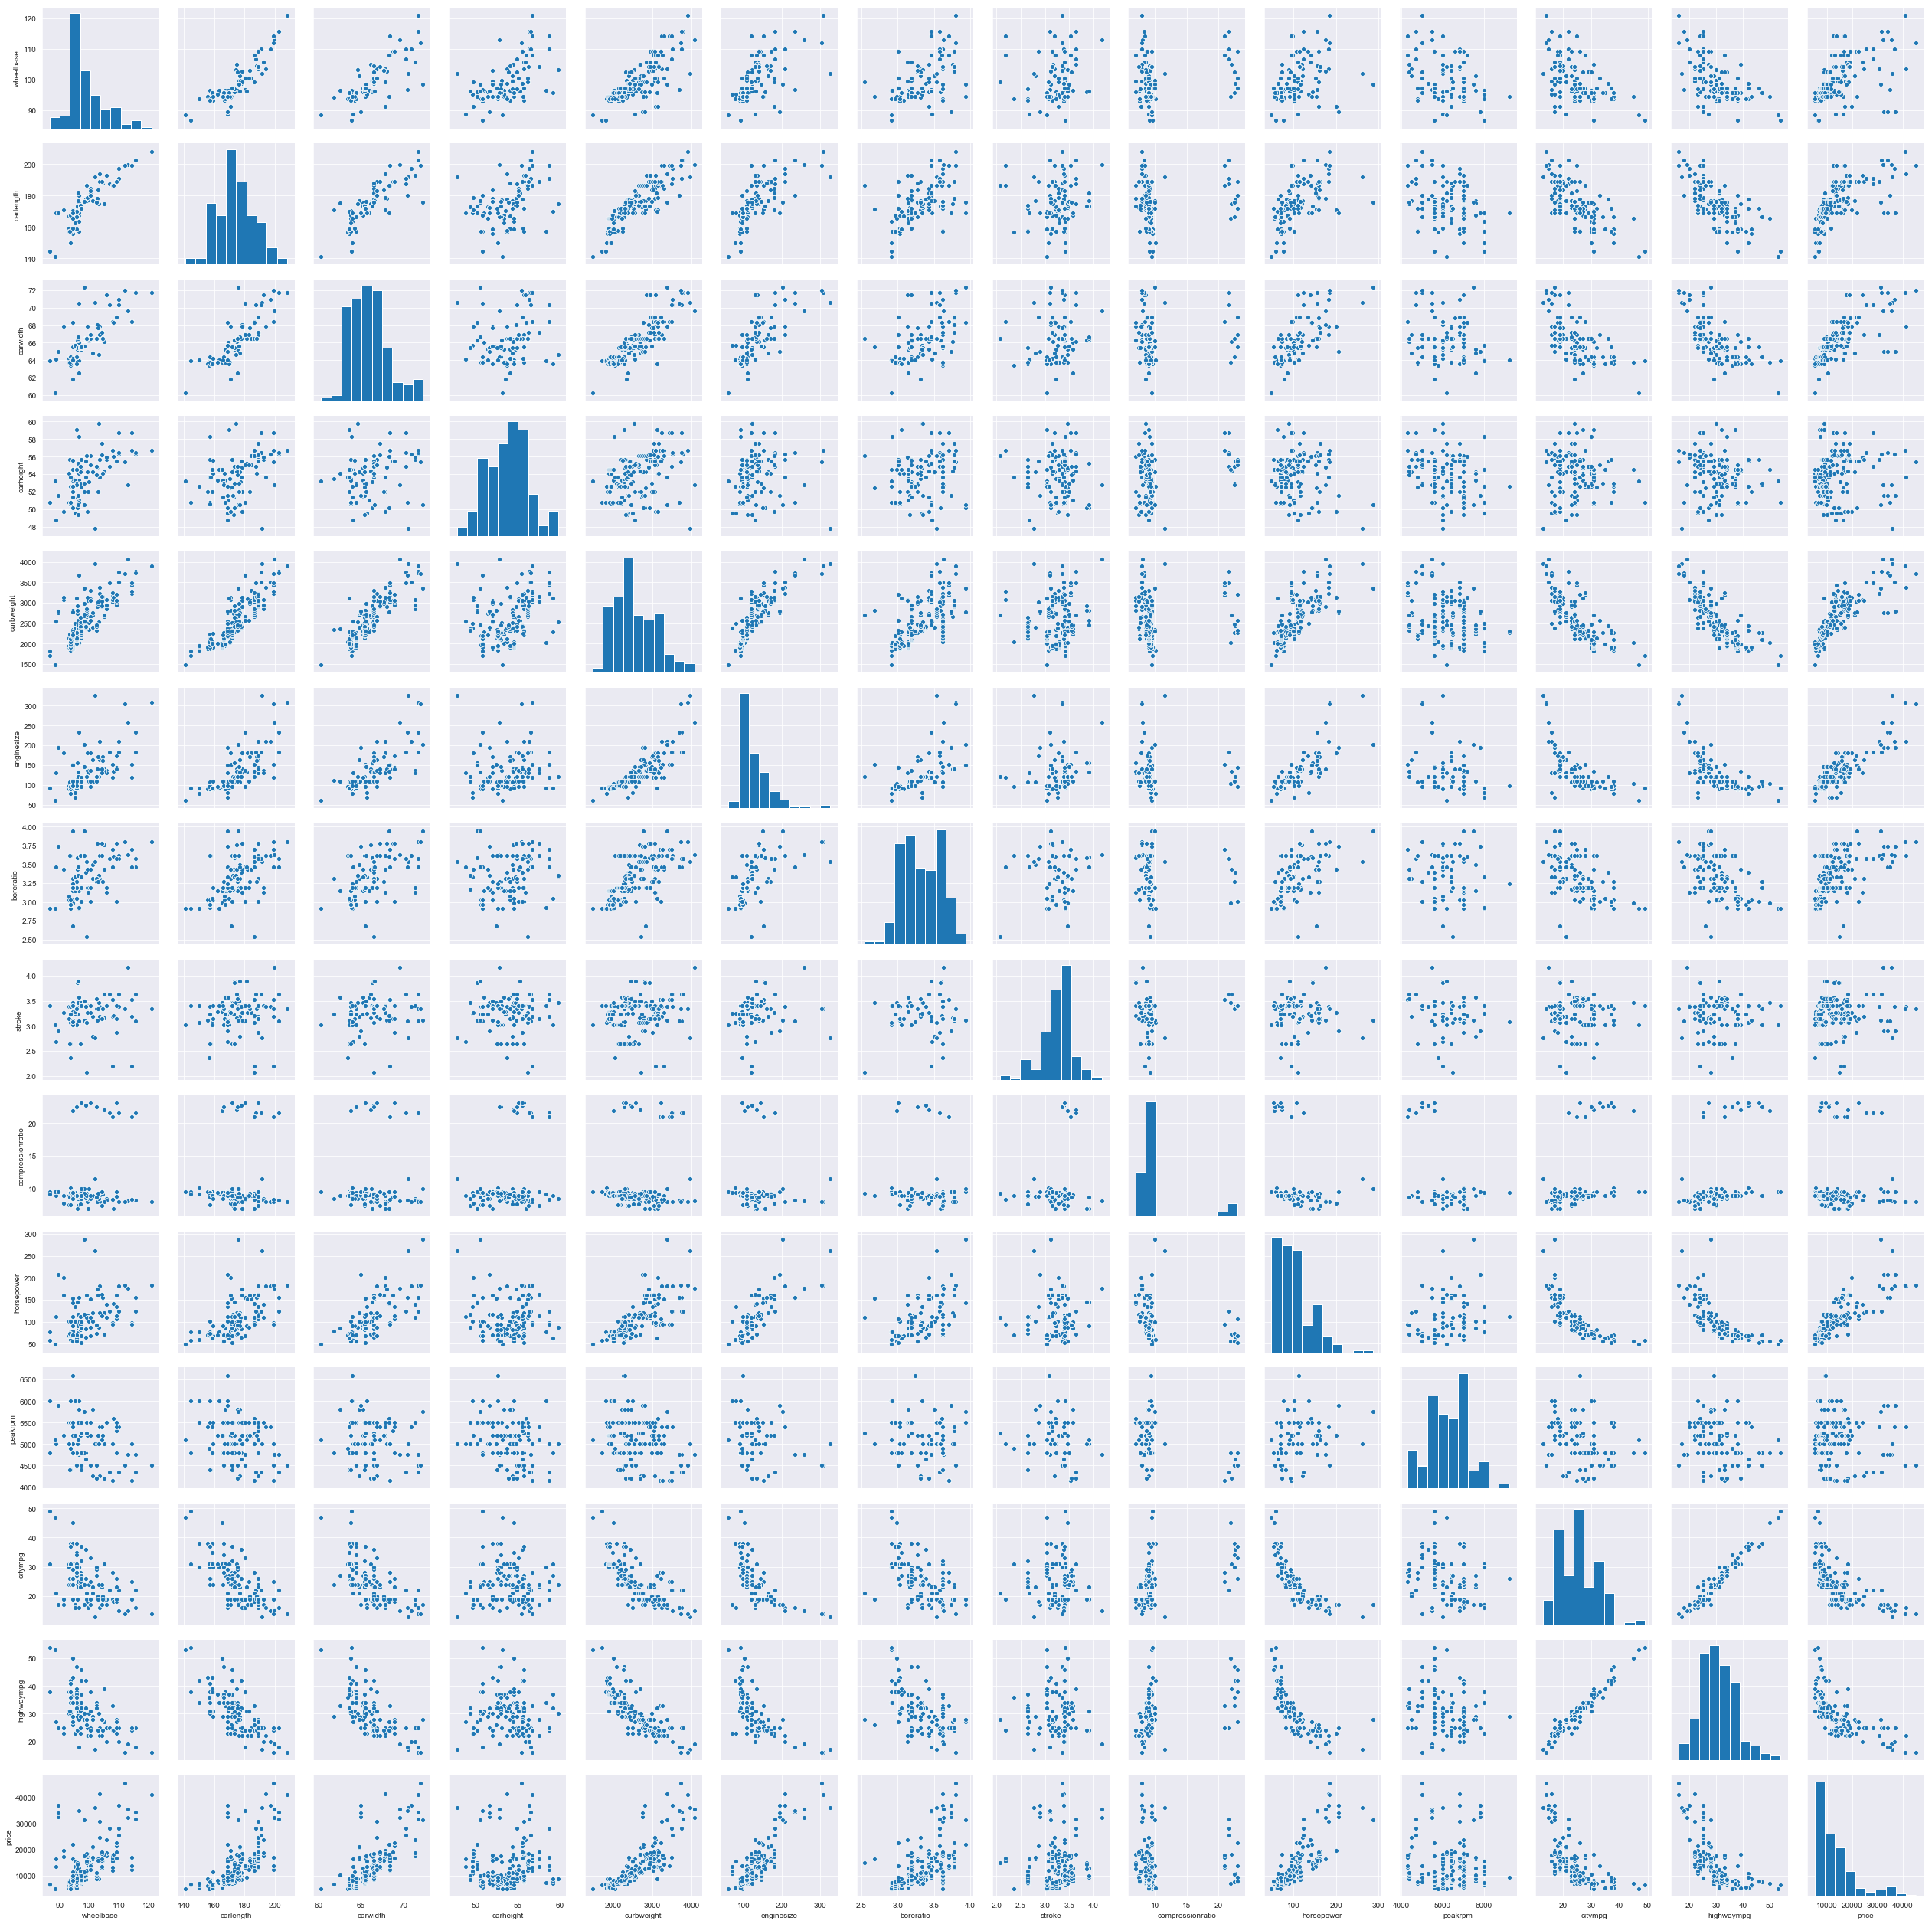

In [317]:
# paiwise scatter plot
plt.figure(figsize=(20, 10))
sns.pairplot(cars_numeric)

#as we can see its difficult to interpret these graphs due to somany of them
#a BETTER way of checking linearity is in below cell

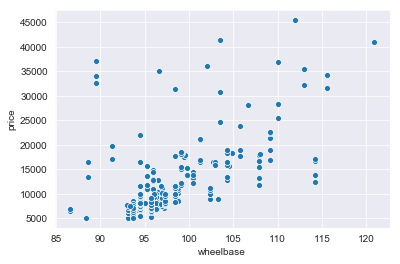

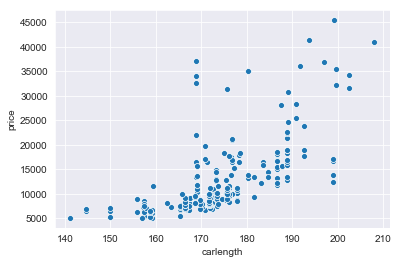

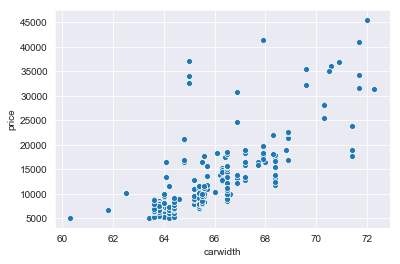

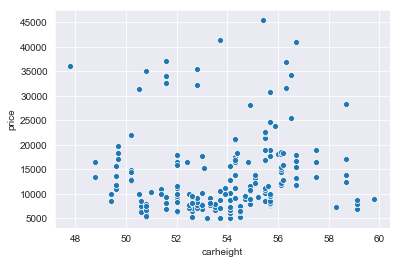

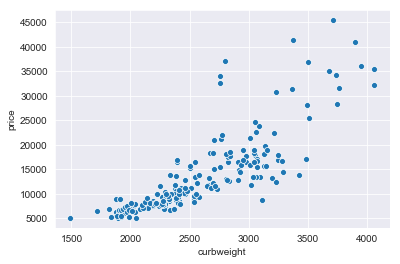

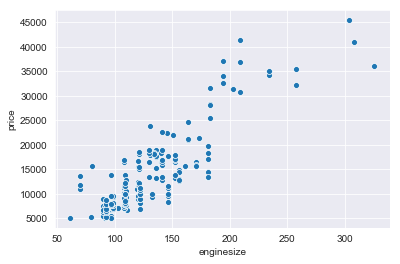

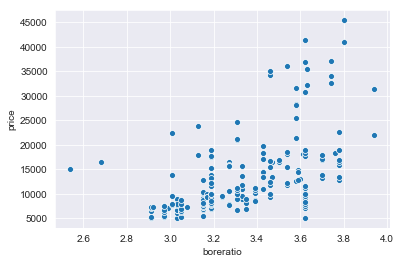

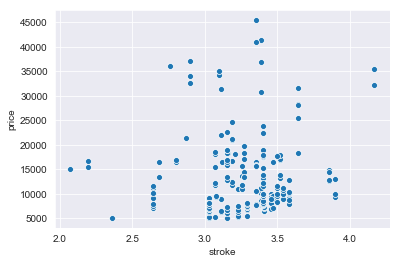

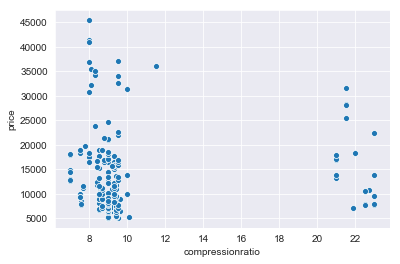

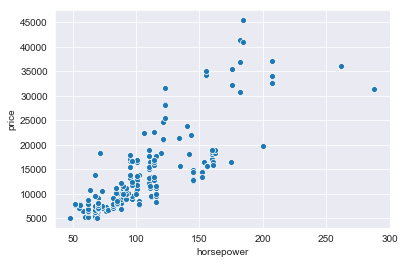

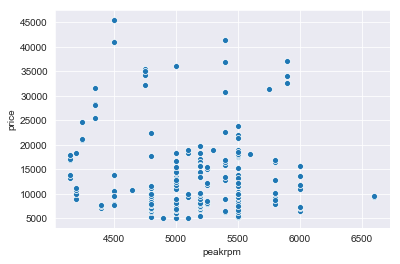

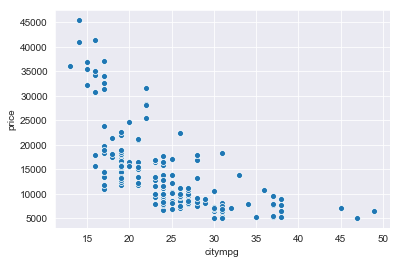

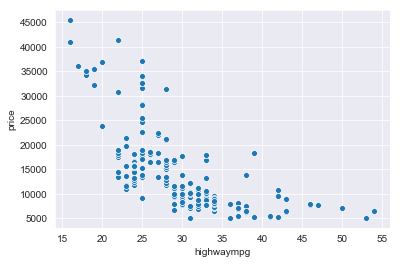

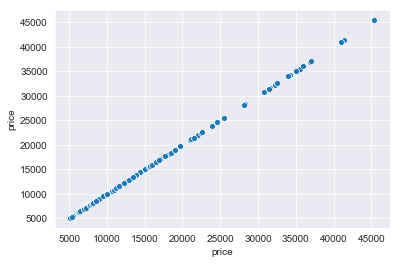

In [318]:
#LINEARITY CHECK>>>#to check price has linear relation or not with Indep. var's

for i, col in enumerate (cars_numeric.columns):
    plt.figure(i)
    sns.scatterplot(x=cars_numeric[col],y=cars_numeric['price'])

<b> 

- These var's appears to have a linear relation with price: carwidth, curbweight, enginesize, horsepower, boreration and citympg. 
    
- Other variables either don't have a relation with price or relationship isn't strong. None of the varibales appear to have polynomial relation with price.

- In linear regression assumptions validation section we will check for linearity assumption in detail 

# Correlation matrix 

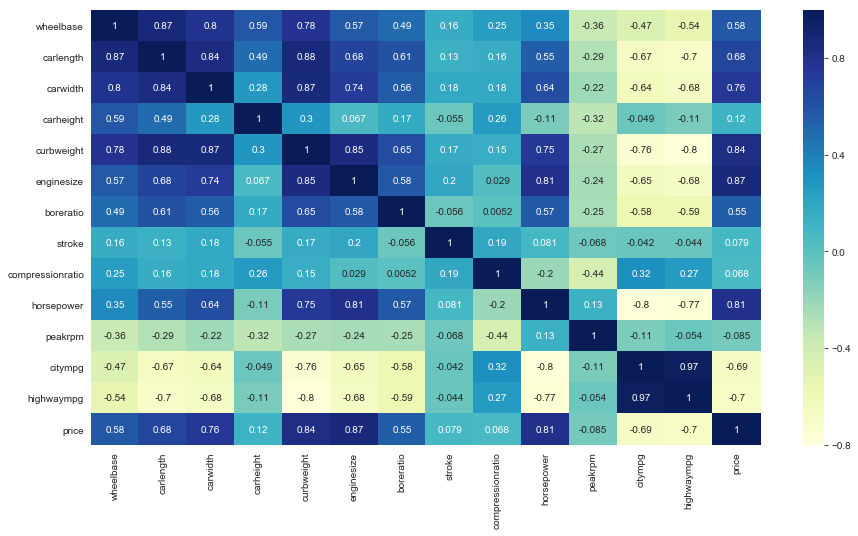

In [319]:
corr=cars_numeric.corr()

plt.figure(figsize=(15,8))
sns.heatmap(corr,annot=True,cmap="YlGnBu")

# Useful insights from Corr Heatmap


 1. <b> Dependent var and indep. var's<b>

> Positive corr: Price highly correlated with enginesize, curbweight, horsepower, carwidth (all of these variables     represent the size/weight/engine power of the car)
    
> Negative corr: Price negatively corr with mpg var's citympg and highwaympg. This suggest that cars having high mileage may fall in the 'economy' cars category or in other words indicates that Low priced cars have mostly high mpg 

2. <b> Correlation among independent variables:<b>

> Many independent variables are highly correlated; wheelbase, carlength, curbweight, enginesize etc. are all measures of         'size/weight', and are positively correlated 


Since indep. var's are highly correlated (more than 80% corr among many of them ) we'll have to pay attention to multicollinearity, which we will check in assumptions validation section using VIF score.

# Section 2: Data Cleaning: Missing values and feature data type check

In [320]:
cars.info()

#no missing values

#all var's in correct format, however since symboling is a categorical var we need to change its type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [321]:
# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null object
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm     

In [322]:
#Extracting car names. car name is the first word (before space)
carnames = cars['CarName'].apply(lambda x: x.split(" ")[0])
carnames[:10]

0    alfa-romero
1    alfa-romero
2    alfa-romero
3           audi
4           audi
5           audi
6           audi
7           audi
8           audi
9           audi
Name: CarName, dtype: object

In [323]:
cars['car_company']=carnames
cars['car_company'].value_counts()

#many car names are duplicates like toyota and toyouta, porsche and porcshce etc.
# we need to fix incorrect spelling and get carnames column in order

toyota         31
nissan         17
mazda          15
mitsubishi     13
honda          13
subaru         12
volvo          11
peugeot        11
volkswagen      9
dodge           9
bmw             8
buick           8
audi            7
plymouth        7
saab            6
porsche         4
isuzu           4
chevrolet       3
alfa-romero     3
jaguar          3
maxda           2
vw              2
renault         2
vokswagen       1
Nissan          1
toyouta         1
mercury         1
porcshce        1
Name: car_company, dtype: int64

In [324]:
#volkswagen
cars.loc[(cars['car_company']=="vw")|(cars['car_company']=="vokswagen"),"car_company"]="volkswagen"

#porsche

cars.loc[(cars['car_company']=="porcshce"),"car_company"]="porsche"

#toyota
cars.loc[(cars['car_company']=="toyouta"),"car_company"]="toyota"

# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'

# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'

cars['car_company'].value_counts()

toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
subaru         12
volkswagen     12
volvo          11
peugeot        11
dodge           9
bmw             8
buick           8
plymouth        7
audi            7
saab            6
porsche         5
isuzu           4
alfa-romero     3
chevrolet       3
jaguar          3
renault         2
mercury         1
Name: car_company, dtype: int64

In [325]:
# drop carname variable
cars = cars.drop('CarName', axis=1)

# Section 3. Data Preparation: feature engineering

In [326]:
X=cars.drop(columns=['price',"car_ID"])
y=cars['price']

In [327]:
# creating dummy variables for categorical variables

cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head(2)


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_company
0,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
1,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero


In [328]:
#creating dummy variables
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()

,symboling_-1,symboling_0,symboling_1,symboling_2,symboling_3,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [329]:
X=X.drop(columns=cars_categorical)
X.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27


In [330]:
X=pd.concat([X,cars_dummies],axis=1)
X.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,...,0,0,0,0,0,0,0,0,0,0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,...,0,0,0,0,0,0,0,0,0,0


# Scaling the features

In [331]:
#scaling features though not necessary in MLR but its good to do it as it makes interpretation of regression coefficients easier

from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols=X.columns
X=pd.DataFrame(scale(X))
X.columns=cols
X.columns

C:\Users\Vikrant Arora\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'symboling_-1', 'symboling_0',
       'symboling_1', 'symboling_2', 'symboling_3', 'fueltype_gas',
       'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_rear', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'car_company_audi',
       'car_company_bmw', 'car_company_buick', 'car_company_chevrolet',


In [332]:
X.describe()

#all means = 0 or as good as zero and std=1

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
count,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,...,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02
mean,-1.496906e-15,3.730349e-15,9.964929e-16,-4.408398e-16,9.910771e-17,5.415722e-19,2.267021e-15,2.126483e-15,-3.115394e-16,1.914458e-16,...,-6.228080e-17,-4.947262e-16,-5.524037e-17,3.076130e-16,-1.252386e-16,-1.437874e-16,8.529762e-17,-7.251652e-16,-6.452833e-16,3.552714e-16
std,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,...,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00
min,-2.023713e+00,-2.677244e+00,-2.620512e+00,-2.430664e+00,-2.055348e+00,-1.586561e+00,-2.923049e+00,-3.789311e+00,-7.931011e-01,-1.422573e+00,...,-3.102526e-01,-2.381198e-01,-1.880254e-01,-1.581139e-01,-9.925833e-02,-1.736397e-01,-2.493515e-01,-4.300827e-01,-2.493515e-01,-2.381198e-01
25%,-7.085959e-01,-6.296552e-01,-8.447824e-01,-7.076263e-01,-7.904486e-01,-7.199469e-01,-6.653141e-01,-4.648342e-01,-3.892993e-01,-8.648707e-01,...,-3.102526e-01,-2.381198e-01,-1.880254e-01,-1.581139e-01,-9.925833e-02,-1.736397e-01,-2.493515e-01,-4.300827e-01,-2.493515e-01,-2.381198e-01
50%,-2.924196e-01,-6.900603e-02,-1.905661e-01,1.538927e-01,-2.725519e-01,-1.662771e-01,-7.312136e-02,1.105560e-01,-2.883489e-01,-2.311186e-01,...,-3.102526e-01,-2.381198e-01,-1.880254e-01,-1.581139e-01,-9.925833e-02,-1.736397e-01,-2.493515e-01,-4.300827e-01,-2.493515e-01,-2.381198e-01
75%,6.065210e-01,7.354037e-01,4.636501e-01,7.282388e-01,7.305117e-01,3.392475e-01,9.262039e-01,4.941494e-01,-1.873985e-01,3.012332e-01,...,-3.102526e-01,-2.381198e-01,-1.880254e-01,-1.581139e-01,-9.925833e-02,-1.736397e-01,-2.493515e-01,-4.300827e-01,-2.493515e-01,-2.381198e-01
max,3.686225e+00,2.766741e+00,2.987056e+00,2.492302e+00,2.907988e+00,4.792679e+00,2.258638e+00,2.923575e+00,3.244916e+00,4.661448e+00,...,3.223180e+00,4.199567e+00,5.318432e+00,6.324555e+00,1.007472e+01,5.759051e+00,4.010403e+00,2.325134e+00,4.010403e+00,4.199567e+00


In [333]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

# Section 4. Model Building and Feature Selection using RFE


<b> Since dependent variable price looks to be linearly related to most of the independent variables we are using Linear Regression only and not other types of regression like Polynomial, Random Forest/Boosting regression etc. <b>

In [334]:
# Model with all features
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

lm=LinearRegression()
lm.fit(X_train,y_train)

y_pred_test=lm.predict(X_test)
y_pred_train=lm.predict(X_train)

In [335]:
## Evaluation metrics

#Rsqaure
from sklearn.metrics import r2_score

print('R-sqaure on train data: {}'.format(r2_score(y_true=y_train, y_pred=y_pred_train)))
print('R-sqaure on test data: {}'.format(r2_score(y_true=y_test, y_pred=y_pred_test)))

#Standard error/RMSE
error_train=y_pred_train-y_train
error_test=y_pred_test-y_test

print('RMSE on train data: {}'.format(((error_train**2).mean())**0.5))
print('RMSE on test data: {}'.format(((error_test**2).mean())**0.5))

R-sqaure on train data: 0.9756892503873289
R-sqaure on test data: 0.8382621393399081
RMSE on train data: 1213.0021196738412
RMSE on test data: 3365.465234388078


<b>Massive overfitting: All features in model is never a good idea unless features are too less and all of them are important, 
so using Recursive feature elimination to reduce dimensionality<b>

# Feature selection using RFE

<b>Lets first decide optimal number of features rather than arbitarily specifying count of features to be used in model in the RFE function <b> 


In [336]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm

n_features_list = list(range(4, 31)) #checking for optimal number of features between 4 to 30
train_adjusted_r2 = []
train_r2 = []
test_r2 = []
train_RMSE=[]
test_RMSE=[]

for n_features in range(4, 31):

    # RFE with n features
    lm = LinearRegression()

    # specifying number of features
    rfe_n = RFE(estimator=lm, n_features_to_select=n_features)

    # fit with n features
    rfe_n.fit(X_train, y_train)

    # selecting features selected by rfe_n
    col_n = X_train.columns[rfe_n.support_] #rfe_n.support_: returns an array with boolean values to indicate whether 
    #an attribute was selected using RFE

    # training & test data for n selected columns
    X_train_rfe_n = X_train[col_n]
    X_test_rfe_n = X_test[col_n]


    # add a constant to the model
    X_train_rfe_n = sm.add_constant(X_train_rfe_n)


    X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')

    
    
    # fitting the model with n featues
    lm_n = sm.OLS(y_train, X_train_rfe_n).fit()
    
    
    # # Making predictions
    y_pred_test = lm_n.predict(X_test_rfe_n)
    y_pred_train = lm_n.predict(X_train_rfe_n)
    
    
    #Calculating evaluation metrics
    
    #R-square
    train_adjusted_r2.append(lm_n.rsquared_adj)
    train_r2.append(lm_n.rsquared)
    test_r2.append(r2_score(y_test, y_pred_test))
    
    #RMSE/stan. error
    error_test=y_pred_test-y_test
    error_train=y_pred_train-y_train
    
    test_RMSE.append(((error_test**2).mean())**0.5)
    train_RMSE.append(((error_train**2).mean())**0.5)
    


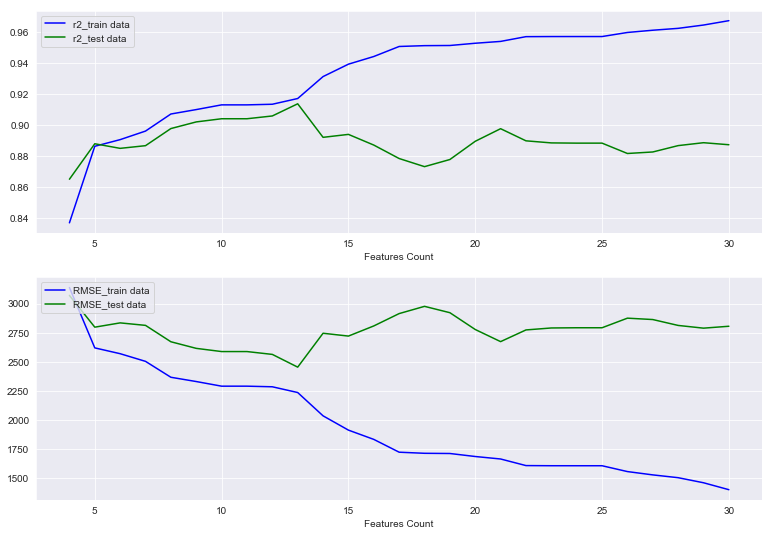

In [337]:
# plotting r2 and RMSE against n_features
fig,ax=plt.subplots(2,1,figsize=(13, 9))
ax[0].plot(n_features_list, train_r2,'b', label="r2_train data")
ax[0].plot(n_features_list, test_r2,'g', label="r2_test data")
ax[0].set_xlabel('Features Count')
ax[1].plot(n_features_list, train_RMSE, 'b',label="RMSE_train data")
ax[1].plot(n_features_list, test_RMSE, 'g',label="RMSE_test data")
ax[1].set_xlabel('Features Count')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.show()

From the above graphs we find: 

1. R sqaure for test data peaks at 13 features and at this point model generalises well  as train R2 is v close to test. Train R2 keep on increasing beyond 13 features but R2 keeps increasing as you add more features to train data. We have select number of features where model accuracy and generalization both are at satisfactory level.

    
2. RMSE for test data is lowest at 13 features and beyond that it increases. Train RMSE at 13 also looks good, adding more features to train decreases RMSE but again there is always a trade off between removing features (aka reducing complexity) and model performance. So we will go with 13 features. 

# Model Bulding with optimal features count

In [338]:
lm=LinearRegression()
rfe=RFE(lm,13)
rfe.fit(X_train,y_train)

col=X_train.columns[rfe.support_] #obtaining fetaure names of 13 most imp 

#making new Df's with  13 most imp features as per RFE algorithm
X_train_13= X_train[col]
X_test_13 = X_test[col]


# add a constant to the model
X_train_13 = sm.add_constant(X_train_13,has_constant='add')
X_test_13 = sm.add_constant(X_test_13,has_constant='add')


#fit OLS model
lm_sm=sm.OLS(y_train,X_train_13).fit()


#making predictions
y_pred_train=lm_sm.predict(X_train_13)
y_pred_test=lm_sm.predict(X_test_13)


#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())


----------------------R-sqaure-------------------------------------------
R-sq for test data is 0.9006167424476529
R-sq for train data is 0.9172871967113265
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 2455.655255247883
RMSE for train data is 2237.4263820988704
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     120.1
Date:                Mon, 08 Jul 2019   Prob (F-statistic):           3.47e-64
Time:                        15:53:32   Log-Likelihood:                -1305.9
No. Observations:                 143   AIC:                             2638.
Df Residuals:                     130   BIC:                             2676.
Df Model:                          12       

<b>Observations from above numbers:
    1. R-sqaure for both test & train looks good
    2. RMSE for both is closer (test is little < train which is fine and shows that model generalizes well)
                                                      
<b> Below Graph also shows predictions are mostly close to Actual values<b>

Text(0.5, 0, 'Index')

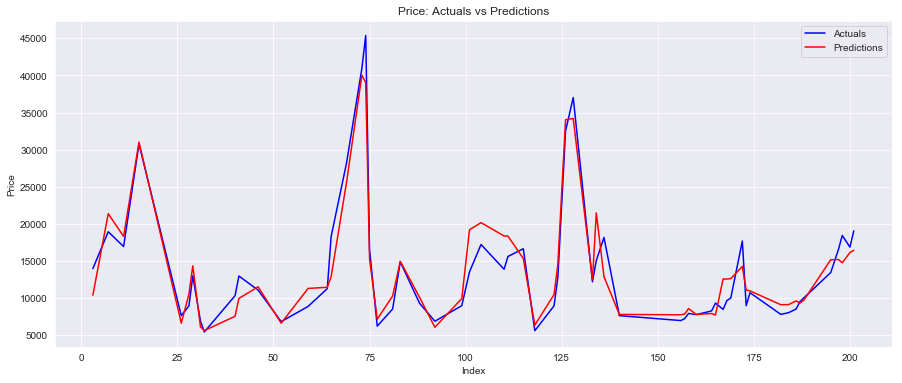

In [339]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_test.index,y=y_test,label='Actuals',color='blue',ax=ax)
sns.lineplot(x=y_test.index,y=y_pred_test,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions')
ax.set_ylabel('Price')
ax.set_xlabel('Index')

In [340]:
#grabbing important features 
features_13=lm_sm.params.index
features_13=features_13[1:] #we don't want constant (const) in our imp features list so removing it
features_13

Index(['carwidth', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'enginelocation_rear', 'enginetype_rotor', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_twelve', 'cylindernumber_two',
       'car_company_bmw', 'car_company_porsche'],
      dtype='object')

In [341]:
X_train[features_13].head(2)

,carwidth,curbweight,enginesize,boreratio,stroke,enginelocation_rear,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_twelve,cylindernumber_two,car_company_bmw,car_company_porsche
122,-0.984972,-0.701886,-0.695874,-1.331531,-0.081241,-0.121867,-0.141069,-0.23812,0.537874,-0.070014,-0.141069,-0.201517,-0.158114
125,1.117866,0.428245,0.579974,2.258638,-0.464834,-0.121867,-0.141069,-0.23812,0.537874,-0.070014,-0.141069,-0.201517,6.324555


# Section 5: Linear Regression Assumptions Validation

# 1. Linearity of the model

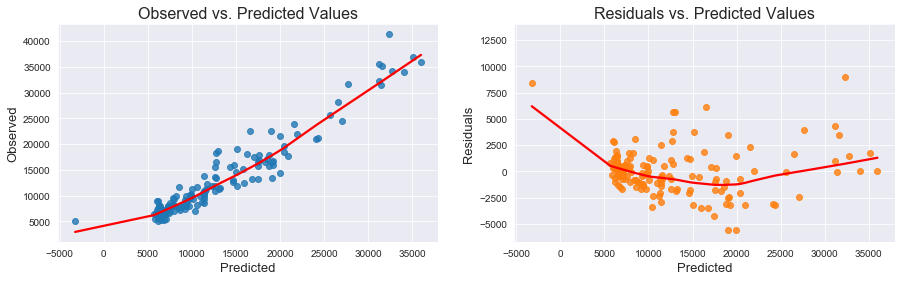

In [342]:
#To detect linearity lets inspect plots of observed vs. predicted values or residuals vs. predicted values. 
#The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot & 
#around horizontal line in the latter one

def linearity_test(model, y):
    
    fitted_vals = model.predict()
    residuals = model.resid
    
    sns.set_style('darkgrid')
    fig,ax=plt.subplots(1,2, figsize=(15,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Observed', fontsize=13)
    
    sns.regplot(x=fitted_vals,y=residuals,lowess=True,ax=ax[1],line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Residuals', fontsize=13)
    
linearity_test(lm_sm, y_train)

<b> From above graphs <b>:
    
    1. Obs vs predicted  shows that most of the values are closer to the daigonal line, however some are not which 
       is a problm
       
    2. Resi vs pred graph does not give a conclusive eviudence that residuals are evenly scattered around the zero line as            Resi. values increase with increase in predicted values, SO ASSUMPTION OF LINEARITY CAN'T BE CONFIRMED. 
    
    3. There seems to be presence of outliers, which might be giving a non-conclusive enough Resi vs Predicted graph. Some             points have very high residual values; a point (~ -3000,~ 8000) shows one value is predicted negatively by the model. There are many other prominent high residual points which could be influential outliers.


# 2. Homoscedasticity (equal variance) of residuals

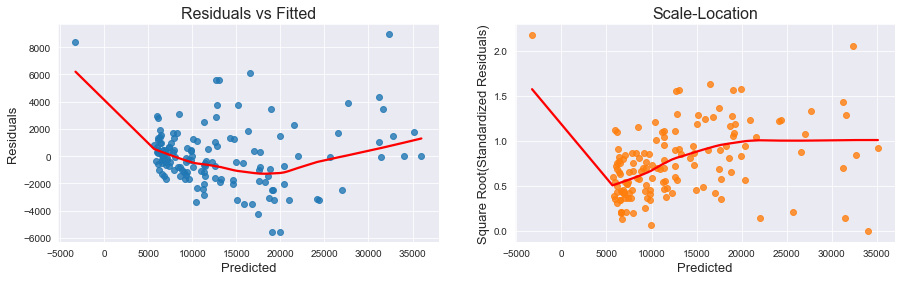

In [343]:
#Homoscedasticity-the variance of the error term must be the same across all levels of independent variables.
#This assumption can be tested by visual inspection of a standardized residual plot by the standardized regression 
#predicted value. Ideally, when the residuals are evenly scattered around the horizontal line, there is presence 
#of homoscedasticity; and when the residuals are not evenly scattered around the horizontal line and takes a various 
#shape like a bowtie, funnel shape, etc., then there is the presence of heteroscedasticity.
 
import statsmodels.stats.api as sms

def homoscedasticity_test(model):
    
    fitted_vals = model.predict()
    residuals = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal
    
    sns.set_style('darkgrid')
    
    
    fig, ax = plt.subplots(1,2,figsize=(15,4))

    sns.regplot(x=fitted_vals, y=residuals, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Residuals', fontsize=13)

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Square Root(Standardized Residuals)', fontsize=13)

      
homoscedasticity_test(lm_sm)

<b>The residuals seem to increas with increase in predicted/fitted values so homoscedasticity could not confirmed, but we will make this graph after removing outliers and check again later in this notebook

# 3. Normality of residuals


<b> When this assumption is violated, it causes problems with calculating confidence intervals and various significance tests for coefficients. When the error distribution significantly departs from Gaussian, confidence intervals may be too wide or too narrow. <b>

Some of the potential reasons causing non-normal residuals:

>presence of a few large outliers in data

>there might be some other problems (violations) with the model assumptions


>another, better model specification might be better suited for this problem

Jarque-Bera test ---- statistic: 61.7387, p-value: 3.9190872769268026e-14
Shapiro-Wilk test ---- statistic: 0.9427, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5455, p-value: 0.0000
Anderson-Darling test ---- statistic: 1.9842, 5% critical value: 0.7660
If the returned Anderson Draling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


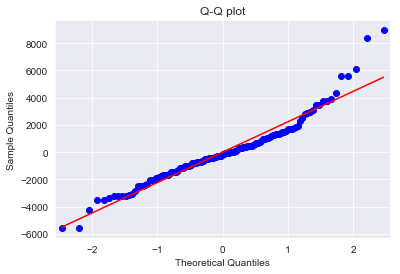

In [344]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');
    

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned Anderson Draling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(lm_sm)

<b> ormality of errors not satisifed as:
    1. Q-Q Plot shows deviation from normal distirbution esp at tails
    2. P-value in first 3 normality tests<0.05 and Anderson-Darling statistic>AD critical value, thus null hypo that 
    errors have normal dist is rejected

The reason could be outliers as we have seen above in Residuals vs Predicted graph that dataset contains outliers <b>

# Identifying Outliers/influential Cases

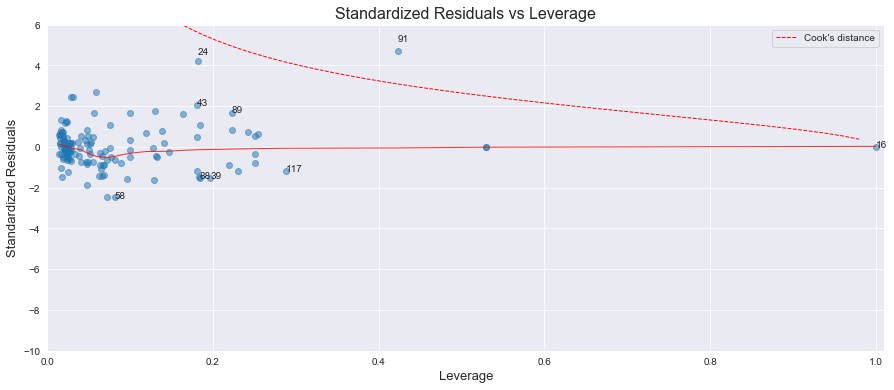

In [345]:
#Function to plot standardized residuals vs Leverage and cook's distance for outlier detection

def influential_outlier_test(model,top_influencing_obs_count):
    
    influence = model.get_influence()

#leverage (hat values)
    leverage = influence.hat_matrix_diag

#When cases are outside of the Cook’s distance (meaning they have high Cook’s distance scores), 
#the cases are influential to the regression results. The regression results will be altered if we exclude those cases.
    cooks_d = influence.cooks_distance

#standardized residuals= (Residual/STD of Residuals)
    standardized_residuals = influence.resid_studentized_internal

#studentized residuals
    studentized_residuals = influence.resid_studentized_external 
    
    
    plot_lm = plt.figure(figsize=(15,6))
    plt.scatter(leverage, standardized_residuals, alpha=0.5)
    sns.regplot(leverage, standardized_residuals,scatter=False,ci=False,lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm.axes[0].set_xlim(0, max(leverage)+0.01)
    plot_lm.axes[0].set_ylim(-10, 6)
    plot_lm.axes[0].set_title('Standardized Residuals vs Leverage',fontsize=16)
    plot_lm.axes[0].set_xlabel('Leverage',fontsize=13)
    plot_lm.axes[0].set_ylabel('Standardized Residuals',fontsize=13);

    # annotations- #annotating index position of the top n cook's D points 
    
    leverage_top_n_obs = np.flip(np.argsort(cooks_d[0]), 0)[:top_influencing_obs_count]  
    
    for i in leverage_top_n_obs:
        plot_lm.axes[0].annotate(i,xy=(leverage[i],studentized_residuals[i])) 
    
    
# shenanigans for cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(lm_sm.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), np.linspace(0.001, max(leverage), 50),'Cook\'s distance')#cookd= 0.5 line
    plt.legend(loc='upper right');
    

influential_outlier_test(model=lm_sm,top_influencing_obs_count=10)
#I am annotating top 10  

#ignore warning it because you can't calculate the square root of a negative number (stackoveflow)

<b> In above graph: We find that 2 observations 16 & 91 are outside cook's distance lines, thus they have to removed . 
Also observation 24 is close to 0.5 cook's line and has a high standardized residual, also removing it (Though I shouldn't as its under cook's d line but since its got big residual I will still do it).

# Outlier removal

In [346]:
#Removing obs 16,24,91 from X_train and y_train

X_train_no_outliers=X_train.drop(index=[16,24,91])
y_train_no_outliers=y_train.drop(index=[16,24,91])

<b> We will be using these for our further analysis:<b> <>X_train_no_outliers   and   y_train_no_outliers<>

# Section 6: Rebuilding the Model: Feature Selection using  RFE & K-Fold Cross Validation

<b> Finding optimal feature count using RFE

In [347]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm

n_features_list = list(range(4, 31)) #checking for optimal number of features between 4 to 30
train_adjusted_r2 = []
train_r2 = []
test_r2 = []
train_RMSE=[]
test_RMSE=[]

for n_features in range(4, 31):

    # RFE with n features
    lm = LinearRegression()

    rfe_n = RFE(estimator=lm, n_features_to_select=n_features)  # specifying number of features

    # fit with n features
    rfe_n.fit(X_train_no_outliers, y_train_no_outliers)

    # selecting the features provided by rfe_n
    col_n = X_train_no_outliers.columns[rfe_n.support_] #rfe_n.support_: returns an array with boolean values to indicate whether 
    #an attribute was selected using RFE

    # subsetting training & test data for n selected columns
    X_train_rfe_n = X_train_no_outliers[col_n]
    X_test_rfe_n = X_test[col_n]


    # add a constant to the model
    X_train_rfe_n = sm.add_constant(X_train_rfe_n,has_constant='add')


    X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')

    
    
    # fitting the model with n featues
    lm_n = sm.OLS(y_train_no_outliers, X_train_rfe_n).fit()
    
    
    # # Making predictions
    y_pred_test = lm_n.predict(X_test_rfe_n)
    y_pred_train = lm_n.predict(X_train_rfe_n)
    
    
    #Calculating evaluation metrics
    
    #R-square
    train_adjusted_r2.append(lm_n.rsquared_adj)
    train_r2.append(lm_n.rsquared)
    test_r2.append(r2_score(y_test, y_pred_test))
    
    #RMSE/stan. error
    error_test=y_pred_test-y_test
    error_train=y_pred_train-y_train_no_outliers
    
    test_RMSE.append(((error_test**2).mean())**0.5)
    train_RMSE.append(((error_train**2).mean())**0.5)

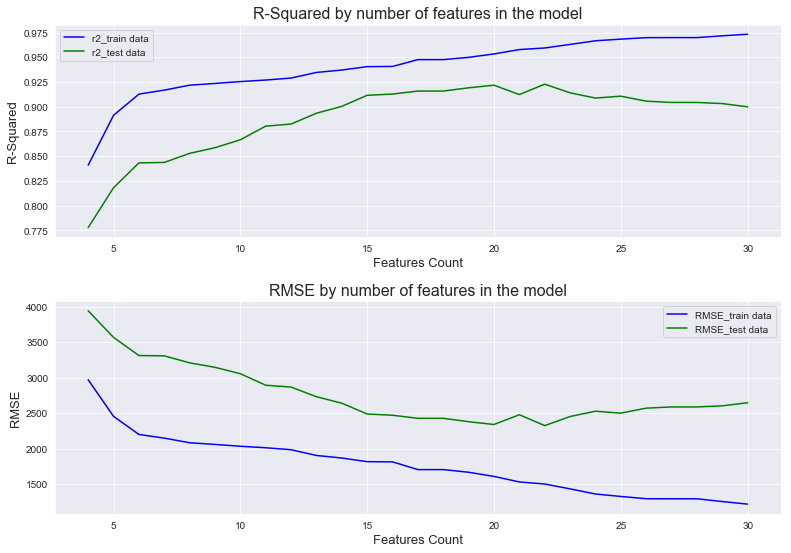

In [348]:
# plotting r2 and RMSE against n_features
fig,ax=plt.subplots(2,1,figsize=(13, 9))
plt.subplots_adjust(hspace = 0.3)
ax[0].plot(n_features_list, train_r2,'b', label="r2_train data")
ax[0].plot(n_features_list, test_r2,'g', label="r2_test data")
ax[0].set_xlabel('Features Count',fontsize=13)
ax[0].set_ylabel('R-Squared',fontsize=13)
ax[0].set_title('R-Squared by number of features in the model',fontsize=16)

ax[1].plot(n_features_list, train_RMSE, 'b',label="RMSE_train data")
ax[1].plot(n_features_list, test_RMSE, 'g',label="RMSE_test data")
ax[1].set_xlabel('Features Count',fontsize=13)
ax[1].set_ylabel('RMSE',fontsize=13)
ax[1].set_title('RMSE by number of features in the model',fontsize=16)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')
plt.show()

<b>From the above graphs we can't select optimal features for the model because:There appaers to be high overfitting as diff between train & test Rsquare and RMSE is very high, the model wont generalize well and lead to bad predictions on test/unseen data. From the below cell we see that test_RMSE is 32% higher than train_RMSE for n_features=4, 45% higher for n_features=5 & so on  indicating high overfitting.

In [349]:
RMSE_test_dividedby_train = [i / j for i, j in zip(test_RMSE, train_RMSE)]
RMSE_test_dividedby_train

[1.327599355360203,
 1.4534968597316593,
 1.5055980115912153,
 1.5396913319619074,
 1.5408275419255348,
 1.5276429629475434,
 1.502612790648262,
 1.4379924380605744,
 1.444961336247328,
 1.4347313411198062,
 1.413597502717755,
 1.3697659273681186,
 1.362346947092296,
 1.4239316352549871,
 1.4239316352549884,
 1.4273034134168991,
 1.4549506534229282,
 1.619050538357614,
 1.5483258481025493,
 1.7116389191615746,
 1.8577727121594612,
 1.8856471598621787,
 1.9862219613703995,
 2.00136426945033,
 2.0014242042629764,
 2.0754095297335735,
 2.1736565940907453]

<b>To remedy overfitting/high performance difference between train & test data, we will do Kfold Cross Validation and try to determine optimal feature count

# Data prep before K-Fold Cross Validation

In [350]:
#Before implementing K-Fold I am removing the outliers from X & Y Df's and creating new ones for CV purpose

X_new_cv = X.drop(index=[16,24,91]) # DF for K fold cross validation (cv)
y_new_cv = y.drop(index=[16,24,91]) 

In [351]:
#Resetting index as we need to use K-fold and thus index needs to be in proper order
X_new_cv.reset_index(inplace=True, drop=True)
X_new_cv.head(20)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
0,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.074449,0.519071,-1.839377,-0.288349,0.174483,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
1,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.074449,0.519071,-1.839377,-0.288349,0.174483,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
2,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,0.604046,-2.404880,0.685946,-0.288349,1.264536,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
3,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.431076,-0.517266,0.462183,-0.035973,-0.053668,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
4,0.107110,0.207256,0.230001,0.235942,0.516807,0.218885,-0.517266,0.462183,-0.540725,0.275883,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
5,0.173698,0.264133,0.183272,-0.256354,-0.093502,0.218885,-0.517266,0.462183,-0.414537,0.149133,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
6,1.172521,1.515437,2.566488,0.810288,0.555313,0.218885,-0.517266,0.462183,-0.414537,0.149133,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
7,1.172521,1.515437,2.566488,0.810288,0.767092,0.218885,-0.517266,0.462183,-0.414537,0.149133,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
8,1.172521,1.515437,2.566488,0.892338,1.021227,0.098522,-0.739338,0.462183,-0.465012,0.909635,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
9,0.123757,0.337262,0.930947,-0.707626,0.957693,0.098522,-0.739338,0.462183,-0.793101,1.416637,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812


In [352]:
y_new_cv.reset_index(drop=True,inplace=True)
y_new_cv.head(20)

0     13495.000
1     16500.000
2     16500.000
3     13950.000
4     17450.000
5     15250.000
6     17710.000
7     18920.000
8     23875.000
9     17859.167
10    16430.000
11    16925.000
12    20970.000
13    21105.000
14    24565.000
15    30760.000
16    36880.000
17     5151.000
18     6295.000
19     6575.000
Name: price, dtype: float64

In [353]:
print(X_new_cv.shape,y_new_cv.shape)

(202, 68) (202,)


# K-Fold Cross Validation

In [354]:
from sklearn.model_selection import KFold


K=5 #using 5 folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)
   
for n_features in range(5,31):
    
    train_RMSE = []
    test_RMSE = []
    train_r2=[]
    test_r2=[]
    
    for train, test in kf.split(X_new_cv):
        
        lm = LinearRegression()
        
        rfe_n = RFE(estimator=lm, n_features_to_select=n_features)
        
        rfe_n.fit(X_new_cv.loc[train],y_new_cv[train])
        
        y_pred_train=rfe_n.predict(X_new_cv.loc[train])
        y_pred_test=rfe_n.predict(X_new_cv.loc[test])
        
        #R-square
        train_r2.append(r2_score(y_pred_train , y_new_cv[train]))
        test_r2.append(r2_score(y_pred_test , y_new_cv[test]))
        
        #Error
        error_train = y_pred_train - y_new_cv[train]
        error_test = y_pred_test - y_new_cv[test]
        rmse_train=((error_train**2).mean())**0.5
        rmse_test=((error_test**2).mean())**0.5
        
        train_RMSE.append(rmse_train)
        test_RMSE.append(rmse_test)
        
    test_times_train=np.mean(test_RMSE)/np.mean(train_RMSE)
         # generate report
    print('n_features:{:1} |train_R2:{:2} |test_R2:{:3} |mean(rmse_train):{:4} |mean(rmse_test):{:5} |RMSE(test/train):{}'.
          format(n_features, round(np.mean(train_r2),4), round(np.mean(test_r2),4),
                 round(np.mean(train_RMSE),0),
                 round(np.mean(test_RMSE),0),round(test_times_train,2)))

n_features:5 |train_R2:0.8756 |test_R2:0.8101 |mean(rmse_train):2566.0 |mean(rmse_test):3214.0 |RMSE(test/train):1.25
n_features:6 |train_R2:0.901 |test_R2:0.8309 |mean(rmse_train):2320.0 |mean(rmse_test):3079.0 |RMSE(test/train):1.33
n_features:7 |train_R2:0.9096 |test_R2:0.8333 |mean(rmse_train):2226.0 |mean(rmse_test):3001.0 |RMSE(test/train):1.35
n_features:8 |train_R2:0.9135 |test_R2:0.8312 |mean(rmse_train):2181.0 |mean(rmse_test):3014.0 |RMSE(test/train):1.38
n_features:9 |train_R2:0.9207 |test_R2:0.8277 |mean(rmse_train):2096.0 |mean(rmse_test):3022.0 |RMSE(test/train):1.44
n_features:10 |train_R2:0.9245 |test_R2:0.825 |mean(rmse_train):2047.0 |mean(rmse_test):3042.0 |RMSE(test/train):1.49
n_features:11 |train_R2:0.9303 |test_R2:0.816 |mean(rmse_train):1969.0 |mean(rmse_test):3048.0 |RMSE(test/train):1.55
n_features:12 |train_R2:0.9322 |test_R2:0.8279 |mean(rmse_train):1946.0 |mean(rmse_test):2973.0 |RMSE(test/train):1.53
n_features:13 |train_R2:0.9346 |test_R2:0.8233 |mean(rms

<b>From the above data we find:
    
1. The model overfits as we increase the number of features (judging by gap b/w test & train RMSE & R2)
2. At n_features=5 test_RMSE is 25% more than train_RMSE meaning predictions on test data are 25% more inaccurate (as RMSE(test/train)=1.25) and 33% wrong with 6 features.

Beyond 6 features this number is 35% or more which is massive overfitting(even with 5/6 features model there is huge gap between train & test RMSE-agreed)

To deal with this I ran the model with 5 and 6 features and found multicollinearity. Features: carwidth and curbweight are highly correlated and latter has a VIF of 7 plus. So when n=6, I remove 'curbweight' leaving us with n=5.

MORE DETAILS BELOW.

****Possible reason for overfitting: SINCE WE ONLY HAVE 200 ODD OBSERVATIONS AND TOTAL OF 68 VARIABLES WE CAN'T EXPECT A VERY ACCURATE MODEL. As per Jim Frost's (famous stats scholar/ & blogger) article on regression overfitting "Statisticians have conducted simulation studies* which indicate you should have at least 10-15 observations for each term in a linear model", so going ny this rule we need a much larger dataset in which each feature is adequatly represented.

https://statisticsbyjim.com/regression/overfitting-regression-models/

# Section 7: Removing Multicollinearity, Model Re-evaluation and Assumptions Validation

# Model with features count=6

In [355]:
import statsmodels.api as sm

lm = LinearRegression()

rfe = RFE(estimator=lm, n_features_to_select=6)

rfe.fit(X_new_cv, y_new_cv)

col= X_new_cv.columns[rfe.support_] 

X_final=X_new_cv[col] #X DF wuith top 6 features only

X_final= sm.add_constant(X_final,has_constant='add')

lm_sm=sm.OLS(y_new_cv,X_final).fit()

print(lm_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     225.8
Date:                Mon, 08 Jul 2019   Prob (F-statistic):           6.29e-85
Time:                        15:54:07   Log-Likelihood:                -1886.3
No. Observations:                 202   AIC:                             3787.
Df Residuals:                     195   BIC:                             3810.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.319e+04    

# Testing Multicollinearity

In [356]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(X_df): #X_df = X_train normally, in this model X=X_final
    '''
     '''
    X_df = add_constant(X_df)
    vifs = pd.Series(
        [1 / (1. - OLS(X_df[col].values, 
                       X_df.loc[:, X_df.columns != col].values).fit().rsquared) 
         for col in X_df],
        index=X_df.columns,
        name='VIF'
    )
    return vifs


In [357]:
variance_inflation_factors(X_final)

const                   1.000162
carwidth                4.229958
curbweight              7.697143
enginesize              4.766423
enginelocation_rear     1.156669
enginetype_l           11.802076
car_company_peugeot    12.601447
Name: VIF, dtype: float64

<b>curbweight  VIF=7.697143, highly correlated with carwidth (0.87 corr coeff) so removing curbweight

In [358]:
X_final =X_final.loc[:,X_final.columns !='curbweight']
X_final.head()

,const,carwidth,enginesize,enginelocation_rear,enginetype_l,car_company_peugeot
0,1.0,-0.844782,0.074449,-0.121867,-0.249351,-0.23812
1,1.0,-0.844782,0.074449,-0.121867,-0.249351,-0.23812
2,1.0,-0.190566,0.604046,-0.121867,-0.249351,-0.23812
3,1.0,0.136542,-0.431076,-0.121867,-0.249351,-0.23812
4,1.0,0.230001,0.218885,-0.121867,-0.249351,-0.23812


# Fitting Linear Model again

In [359]:
lm_sm=sm.OLS(y_new_cv,X_final).fit()

y_predictions=lm_sm.predict(X_final)


#Standard error/RMSE
error=y_predictions-y_new_cv

print('RMSE is: {}'.format(((error**2).mean())**0.5))

print(lm_sm.summary())

RMSE is: 2897.5771368374594
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     241.4
Date:                Mon, 08 Jul 2019   Prob (F-statistic):           1.02e-81
Time:                        15:54:08   Log-Likelihood:                -1896.9
No. Observations:                 202   AIC:                             3806.
Df Residuals:                     196   BIC:                             3826.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const 

Text(0, 0.5, 'Car Price')

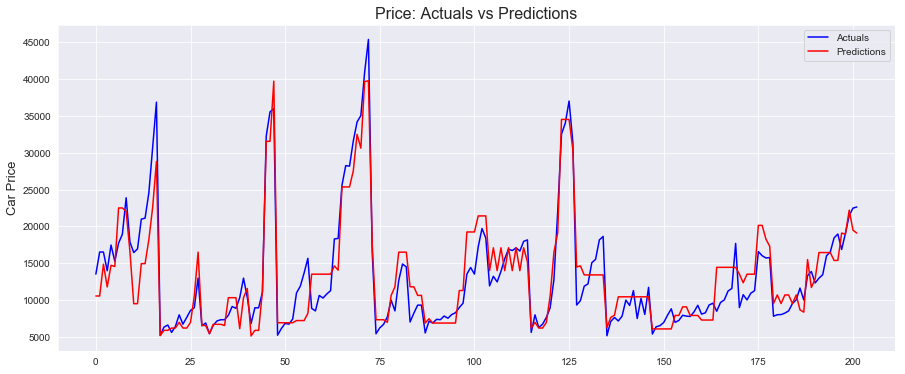

In [360]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_new_cv.index,y=y_new_cv,label='Actuals',color='blue',ax=ax)
sns.lineplot(x=y_new_cv.index,y=y_predictions,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions', fontsize=16)
ax.set_ylabel('Car Price',fontsize=13)

<b> Graph shows predictions miss the actual values at some places but given that we want to avoid overfitting and want the model to generalize well and perform well on unseen test data we will have to compromise a bit (bias-variance tradeoff)

# Again Checking Assumptions for new model

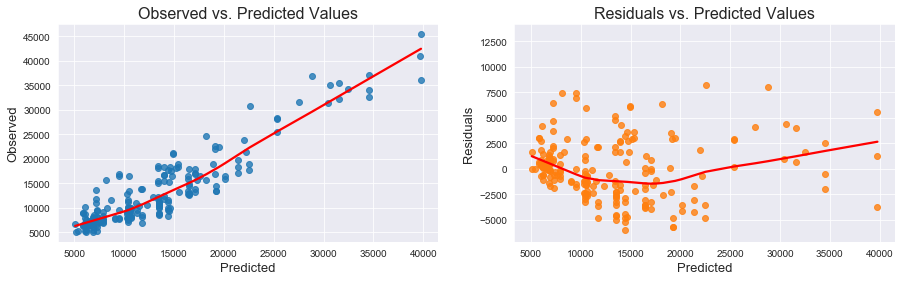

In [361]:
linearity_test(lm_sm,y_new_cv)

#Residuals more or less evenly scattered vs predicted values-looks fine

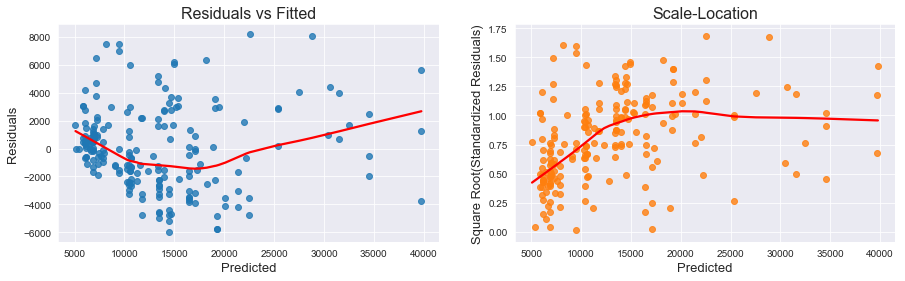

In [362]:
homoscedasticity_test(lm_sm)

#both graphs show evenly spread residuals so homoscedasticity is present

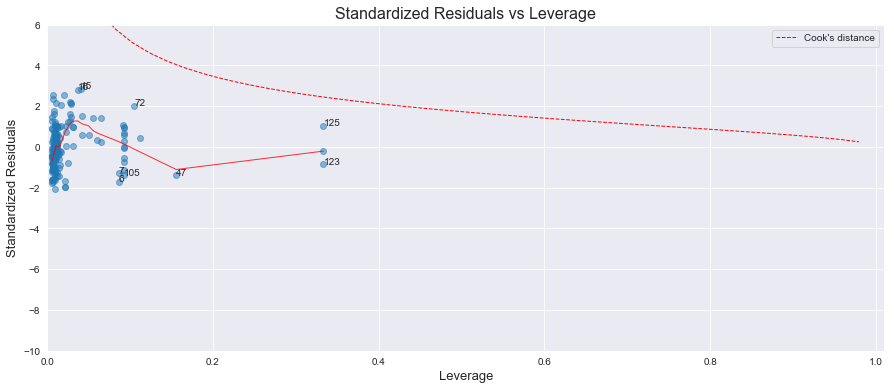

In [363]:
influential_outlier_test(model=lm_sm,top_influencing_obs_count=10)

#looks fine not influential outlier

Jarque-Bera test ---- statistic: 6.5391, p-value: 0.03802295487204688
Shapiro-Wilk test ---- statistic: 0.9824, p-value: 0.0126
Kolmogorov-Smirnov test ---- statistic: 0.5149, p-value: 0.0000
Anderson-Darling test ---- statistic: 0.6878, 5% critical value: 0.7720
If the returned Anderson Draling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


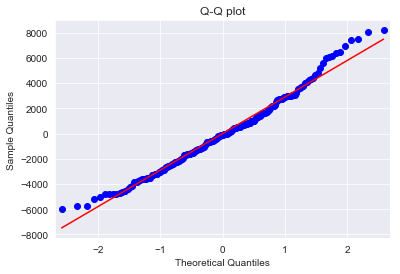

In [364]:
normality_of_residuals_test(lm_sm)

#Q-Q plot shows residuals is mostly normal except at upper tail, but other 4 tests all show normality at 5% signi. level

<b> The final model meets all the assumptions including no mutlicollinearity & no outliers and has an R-Square of 86%. 
Here I end my project, Thank God it was taxing but a great experience as I learned so much. <b>

References
    
https://statisticsbyjim.com/regression/overfitting-regression-models/

https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
    